In [4]:
import spectral_graph as sg
import util
import time
import numpy as np
import matplotlib.pyplot as mpl
from scipy.signal import lfilter, firls, decimate

add some description here

In [5]:
hcp_dir = util.get_absolute_path('./data/')

# Get structural connectivity matrix + distance between regions
Cdk_conn, Ddk_conn, perm_HCP = sg.get_HCP_connectome(hcp_dir)
perm_Julia, empty_Julia, cort_Julia = sg.get_Julia_order()

# Some other ordering that was in the original code:
linds = np.concatenate([np.arange(0,34), np.arange(68,77)])
rinds = np.concatenate([np.arange(34,68), np.arange(77,86)])

In [6]:
q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])

In [7]:
Cdk_conn = sg.bi_symmetric_c(Cdk_conn, linds, rinds)
C = sg.reduce_extreme_dir(Cdk_conn)

In [8]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


In [10]:
# Compute for all frequencies in fvec - this is the debug part in Ashish's SCFC_onJuliaMEG3.m
#freqresp = []

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = sg.network_transfer_function(C, Ddk_conn, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)
# np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Computation time =  0.43387794494628906


### Plotting

In [ ]:
# Plotting eigen values of each eigen vector
#mpl.figure(num=5)
fig_ev, ax_ev = mpl.subplots(1,3, figsize = (20,3), sharey = True)
for i in np.arange(0,evec.shape[1]):
    ax_ev[0].scatter(np.abs(evec[:,i]), np.ones(evec.shape[0])*(i+1), c = np.arange(0,fvec.size))
    
ax_ev[0].grid(True)
ax_ev[0].set_xlabel('Eigen Value')
ax_ev[0].set_ylabel('Eigen Vector #')
ax_ev[0].set_title('Corresponding Eigen Values')
#mpl.savefig('ev_Vv_plot.png', dpi = 300, format = 'png')

# Plotting eigen vector's frequency response with default parameters
ev_freqresp = np.abs(np.transpose(fqall))
#fig_ev, ax_ev = mpl.subplots()
ax_ev[1].imshow(sg.mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
#fig_ev.colorbar(ax1)
ax_ev[1].set_title('Freq. Response of Eigen Vectors - Default Parameters')
ax_ev[1].set_xlabel('Frequency (Hz)')
#mpl.savefig('freqresp_eigs_default.png', dpi = 300, format = 'png')

# eig vs. freq figure with set of optimized parameters
evec = []
Vvec =[]
fqall = []
freq_model = []

# opparam = loadmat('/home/axiezai/lab/SCFC_eeg/data/SCFC_opparam_HCP.mat')
# optau_e = opparam['output']['param'][0,1][0]
# optau_i = opparam['output']['param'][0,1][1]
# opalpha = opparam['output']['param'][0,1][2]
# opspeed = opparam['output']['param'][0,1][3]
# opgei = opparam['output']['param'][0,1][4]
# opgii = opparam['output']['param'][0,1][5]
# optauC = opparam['output']['param'][0,1][6]

for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = sg.network_transfer_function(C, Ddk_conn, w) #,tau_e = optau_e, tau_i = optau_i, alpha = opalpha, 
                                                          #speed = opspeed, gei = opgei, gii = opgii, tauC = optauC)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

# Plotting eigen vector's frequency response
ev_freqresp = np.abs(np.transpose(fqall))
ax1 = ax_ev[2].imshow(sg.mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
fig_ev.colorbar(ax1)
ax_ev[2].set_title('Freq. Response of Eigen Vectors - Optimized Parameters')
ax_ev[2].set_xlabel('Frequency (Hz)')
mpl.savefig('freqresp_eigs.png', dpi = 300, format = 'png')

## Plotting Magnitudes

Text(0, 0.5, 'Magnitude (dB)')

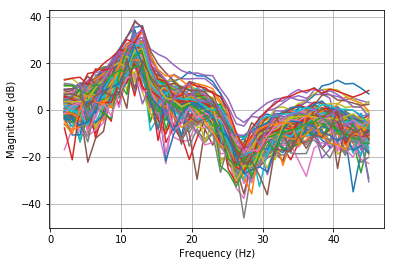

In [43]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,sg.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))